In [1]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy.contrasts import Diff
import scipy.stats as stats
import pandas as pd 
import numpy as np
import seaborn as sns

In [17]:
full_data = pd.read_csv('../data/regression_data.csv')
data = full_data.loc[(full_data.trial > 20) & (full_data.trial < 201)]

In [3]:
# log transform inital movement vector/theta 
data['log_imv'] = np.log(data.initial_theta)
data

,trial,initial_theta,previous_uncertainty,rot,log_imv
21,21,6.906684,high_uncertainty,10.116229,1.932490
22,22,5.529740,high_uncertainty,7.950982,1.710141
23,23,5.044012,high_uncertainty,13.922142,1.618202
24,24,5.535144,unlimited_uncertainty,10.139899,1.711118
25,25,5.312538,no_uncertainty,4.127973,1.670070
...,...,...,...,...,...
196,196,6.081739,high_uncertainty,20.970128,1.805291
197,197,5.769439,unlimited_uncertainty,8.199016,1.752575
198,198,5.168634,low_uncertainty,15.782782,1.642608
199,199,5.133350,unlimited_uncertainty,17.707489,1.635758


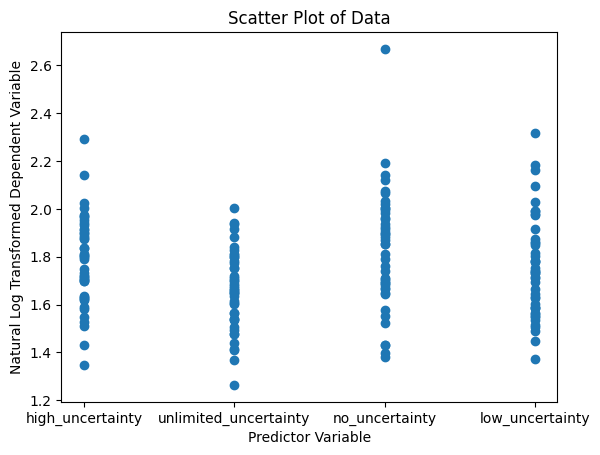

In [4]:
# Create a scatter plot of the transformed dependent variable vs. predictor variable(s)
plt.scatter(data['previous_uncertainty'], data['log_imv'])
plt.xlabel('Predictor Variable')
plt.ylabel('Natural Log Transformed Dependent Variable')
plt.title('Scatter Plot of Data')
plt.show()

In [5]:
data['z_score'] = (data['log_imv'] - data['log_imv'].mean()) / data['log_imv'].std()
outliers = data[np.abs(data['z_score']) > 3]

# 4 outliers (more than 3 sd)
outliers

,trial,initial_theta,previous_uncertainty,rot,log_imv,z_score
69,69,14.408717,no_uncertainty,18.091531,2.667833,4.332973


In [6]:
#Remove outliers 
cleaned_data = data[np.abs(data['z_score']) <= 3].copy()

cleaned_data


,trial,initial_theta,previous_uncertainty,rot,log_imv,z_score
21,21,6.906684,high_uncertainty,10.116229,1.932490,0.835242
22,22,5.529740,high_uncertainty,7.950982,1.710141,-0.222380
23,23,5.044012,high_uncertainty,13.922142,1.618202,-0.659697
24,24,5.535144,unlimited_uncertainty,10.139899,1.711118,-0.217734
25,25,5.312538,no_uncertainty,4.127973,1.670070,-0.412983
...,...,...,...,...,...,...
196,196,6.081739,high_uncertainty,20.970128,1.805291,0.230209
197,197,5.769439,unlimited_uncertainty,8.199016,1.752575,-0.020539
198,198,5.168634,low_uncertainty,15.782782,1.642608,-0.543605
199,199,5.133350,unlimited_uncertainty,17.707489,1.635758,-0.576187


In [7]:
# calculate the change in IMV/initial theta from trial to the next trial and natural log transform
change_imv = np.diff(a=cleaned_data.initial_theta, n=1, axis=-1, prepend=0)

cleaned_data['log_change_imv'] = np.log(abs(change_imv))


In [8]:
# create formulas for regressions 
formula = 'log_imv ~ trial + C(previous_uncertainty, Diff) * rot + 1'
formula_2 = 'log_change_imv ~ C(previous_uncertainty, Diff) * rot + 1 '

### Regression 1: 
Regresses initial movement vector (initial_theta) on midpoint error (midpoint_error), trial (log_trial) and midpoint sensory uncertainty on the previous trial (previous_uncertainty) as well as the interaction between midpoint error and uncertainty on the previous trial. 

In [9]:
# Regression 1 
# Create and train the linear regression model with statsmodels
model = smf.ols(formula, data=cleaned_data)

# fit the model 
reg = model.fit()

# Get the summary of the regression model, including p-values
summary = reg.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                log_imv   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     3.186
Date:                Sun, 10 Sep 2023   Prob (F-statistic):            0.00215
Time:                        20:16:13   Log-Likelihood:                 47.645
No. Observations:                 179   AIC:                            -77.29
Df Residuals:                     170   BIC:                            -48.60
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [10]:
# get cook's distance 
influence = reg.get_influence()
cook_distance = influence.cooks_distance[0]
outliers_cook = cleaned_data[cook_distance > 4 / len(data)]
outliers_cook

# cleaned_data = data[cook_distance <= 4 / len(data)]


,trial,initial_theta,previous_uncertainty,rot,log_imv,z_score,log_change_imv
31,31,9.880397,high_uncertainty,14.998345,2.290553,2.538402,0.993817
43,43,8.120655,low_uncertainty,2.217902,2.094411,1.605436,0.492765
47,47,10.118462,low_uncertainty,6.724195,2.314362,2.651652,0.768930
61,61,3.542360,unlimited_uncertainty,15.191315,1.264793,-2.340717,1.230538
68,68,4.637046,low_uncertainty,5.784814,1.534078,-1.059841,-2.478388
70,70,8.949136,no_uncertainty,1.901798,2.191557,2.067520,1.461423
136,136,4.257350,low_uncertainty,3.078460,1.448647,-1.466200,0.620812
137,137,3.978771,no_uncertainty,4.594640,1.380973,-1.788098,-1.278051
144,144,3.852237,high_uncertainty,17.615544,1.348654,-1.941826,-0.131586
156,156,8.689094,low_uncertainty,6.381272,2.162069,1.927256,1.183919


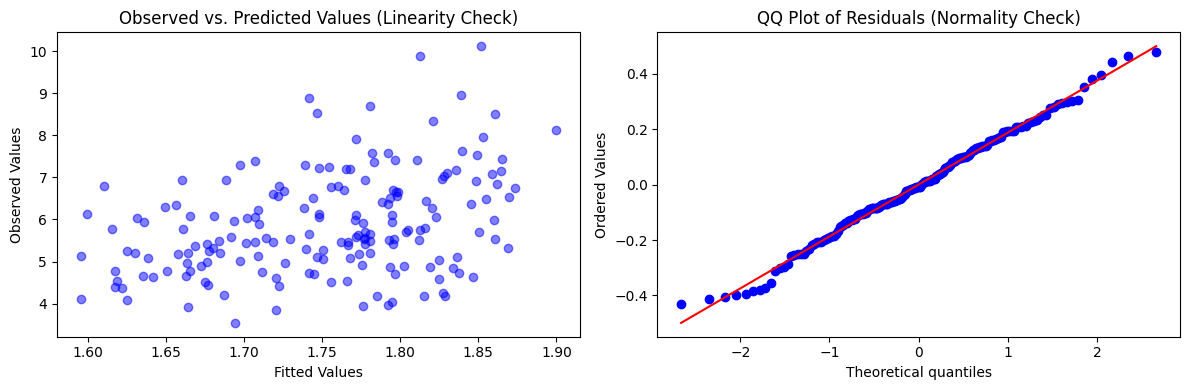

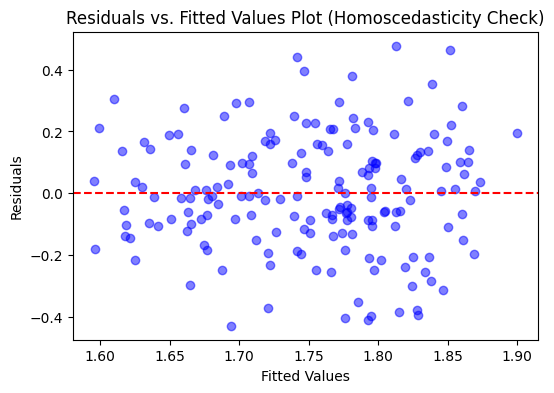

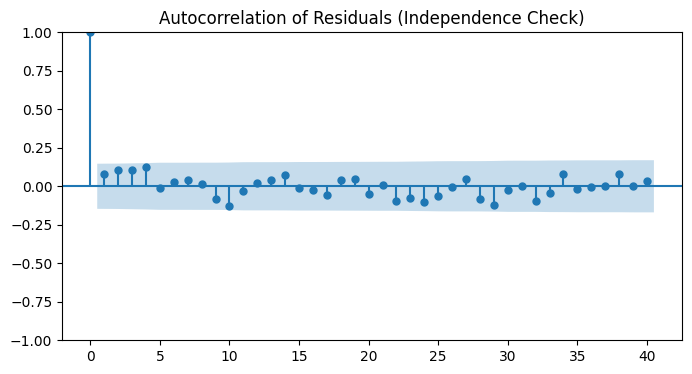

                                            Variable        VIF
0                                          Intercept  12.030095
1  C(previous_uncertainty, Diff)[D.high_uncertainty]  15.389115
2   C(previous_uncertainty, Diff)[D.low_uncertainty]  17.343612
3    C(previous_uncertainty, Diff)[D.no_uncertainty]  11.774821
4                                              trial   1.047810
5                                                rot   1.050059
6  C(previous_uncertainty, Diff)[D.high_uncertain...  14.807946
7  C(previous_uncertainty, Diff)[D.low_uncertaint...  17.148264
8  C(previous_uncertainty, Diff)[D.no_uncertainty...  12.102205


In [11]:
residuals = reg.resid
fitted_values = reg.fittedvalues

# Linearity Check (Observed vs. Predicted)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(fitted_values, cleaned_data['initial_theta'], color='blue', alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Observed Values')
plt.title('Observed vs. Predicted Values (Linearity Check)')

# Normality of Residuals (QQ Plot)
plt.subplot(1, 2, 2)
stats.probplot(residuals, plot=plt)
plt.title('QQ Plot of Residuals (Normality Check)')

plt.tight_layout()
plt.show()

# Homoscedasticity Check (Residuals vs. Fitted Values)
plt.figure(figsize=(6, 4))
plt.scatter(fitted_values, residuals, color='blue', alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot (Homoscedasticity Check)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Independence of Residuals (Autocorrelation Plot)
fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_acf(residuals, ax=ax, lags=40)
plt.title('Autocorrelation of Residuals (Independence Check)')
plt.show()

# Multicollinearity Check (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = reg.model.data.orig_exog
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)



### Regression 2 
Regresses **change** in IMV (between trials) on midpoint error and midpoint sensory uncertainty on the previous trial as well as the interaction between midpoint error and uncertainty on the previous trial. 

In [12]:
# Regression 2
# Create and train the linear regression model with statsmodels
model_2 = smf.ols(formula_2, data=cleaned_data)

# fit the model 
reg_2 = model_2.fit()

# Get the summary of the regression model, including p-values
summary_2 = reg_2.summary()
print(summary_2)

                            OLS Regression Results                            
Dep. Variable:         log_change_imv   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.802
Date:                Sun, 10 Sep 2023   Prob (F-statistic):             0.0897
Time:                        20:16:13   Log-Likelihood:                -281.64
No. Observations:                 179   AIC:                             579.3
Df Residuals:                     171   BIC:                             604.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

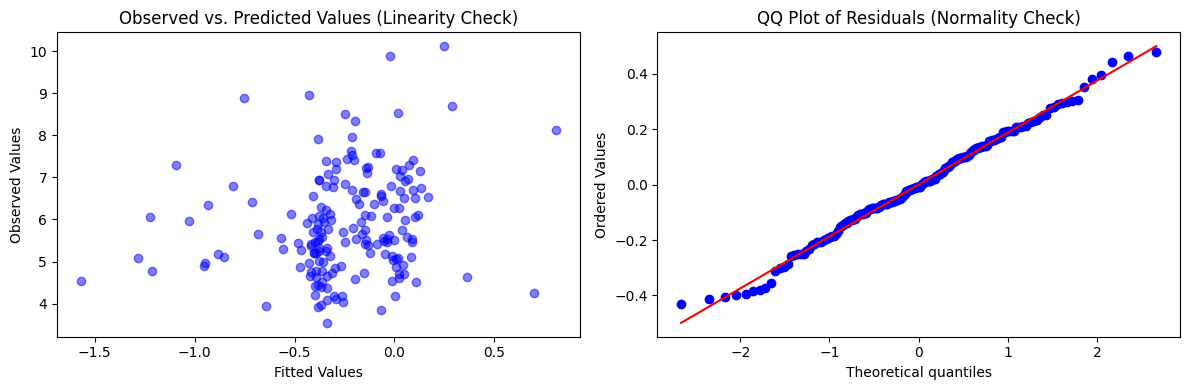

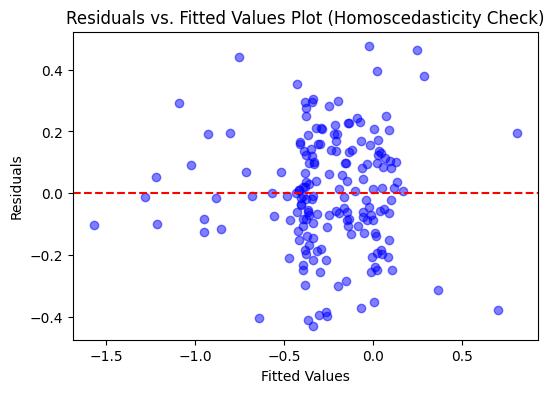

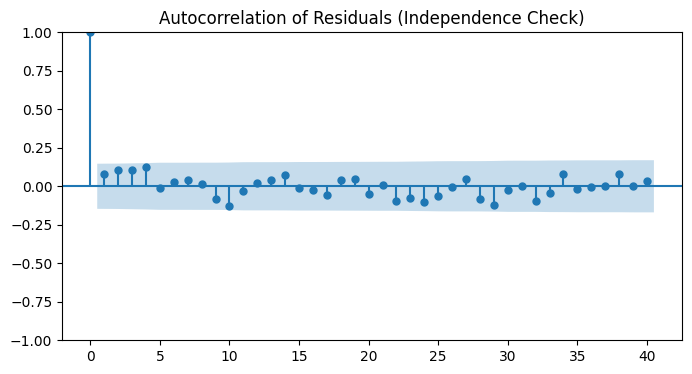

                                            Variable        VIF
0                                          Intercept  12.030095
1  C(previous_uncertainty, Diff)[D.high_uncertainty]  15.389115
2   C(previous_uncertainty, Diff)[D.low_uncertainty]  17.343612
3    C(previous_uncertainty, Diff)[D.no_uncertainty]  11.774821
4                                              trial   1.047810
5                                                rot   1.050059
6  C(previous_uncertainty, Diff)[D.high_uncertain...  14.807946
7  C(previous_uncertainty, Diff)[D.low_uncertaint...  17.148264
8  C(previous_uncertainty, Diff)[D.no_uncertainty...  12.102205


In [13]:
#assumption testing 
residuals_2 = reg_2.resid
fitted_values = reg_2.fittedvalues

# Linearity Check (Observed vs. Predicted)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(fitted_values, cleaned_data['initial_theta'], color='blue', alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Observed Values')
plt.title('Observed vs. Predicted Values (Linearity Check)')

# Normality of Residuals (QQ Plot)
plt.subplot(1, 2, 2)
stats.probplot(residuals, plot=plt)
plt.title('QQ Plot of Residuals (Normality Check)')

plt.tight_layout()
plt.show()

# Homoscedasticity Check (Residuals vs. Fitted Values)
plt.figure(figsize=(6, 4))
plt.scatter(fitted_values, residuals, color='blue', alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot (Homoscedasticity Check)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Independence of Residuals (Autocorrelation Plot)
fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_acf(residuals, ax=ax, lags=40)
plt.title('Autocorrelation of Residuals (Independence Check)')
plt.show()

# Multicollinearity Check (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = reg.model.data.orig_exog
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


### Repeated Measures / Paired T-test 
Compares the last 3 trials of the adaptaiton phase (trial 198 to 200) and the first 3 trials of the washout phase (trial 201 to 203). 

In [23]:
# ttest 
adaptation = full_data.loc[(full_data.trial <= 200) & (full_data.trial >= 198)]
washout = full_data.loc[(full_data.trial >= 201) & (full_data.trial <= 203)]


In [25]:
#manual checking of last 3 adapation trials
full_data.loc[(full_data.trial <= 200) & (full_data.trial >= 198)]

,trial,initial_theta,previous_uncertainty,rot
198,198,5.168634,low_uncertainty,15.782782
199,199,5.133350,unlimited_uncertainty,17.707489
200,200,5.286212,no_uncertainty,0.000000


In [26]:
#manual checking of first 3 washout trials
full_data.loc[(full_data.trial >= 201) & (full_data.trial <= 203)]

,trial,initial_theta,previous_uncertainty,rot
201,201,4.329746,unlimited_uncertainty,0.0
202,202,3.752025,unlimited_uncertainty,0.0
203,203,3.971641,unlimited_uncertainty,0.0


In [27]:
stats.ttest_rel(adaptation.initial_theta, washout.initial_theta)

TtestResult(statistic=6.899391112882354, pvalue=0.02036807004120347, df=2)